# Milestone Project 1:Food Vision Big

## Check GPU

* Google colab offers free GPUs, however not all of them are compatible with mixed precision training.

However Tesla T4 is now the default GPU provided and it is compatible.


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-80eddf31-22da-4894-27ea-1bcfb86504e1)



## Get helper functions

In past modules, we created a bunch of helper functions to do small tasks required for our notebooks.

Rather than reqrite all of these, we can import a script and load them in here.

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-29 16:53:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-29 16:53:18 (119 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use Tensorflow Datasets to Download Data



In [ ]:
# Get Tensorflow datasets
import tensorflow_datasets as tfds

In [ ]:
# List of all available datasets
datasets_list = tfds.list_builders() #get all avilable datasets in TFDS
print("food101" in datasets_list) # is our dataset in the list?

True


In [ ]:
# Load in the data (takes 5-6 minutes in colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, #data gets rerturned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete96NDNB/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete96NDNB/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the  Food101 data from Tensorflow Datasets

To become one with the data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one hot encoded or are they label encoded)
* Do the labels match up with the class names?



In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in fomrat(image_tensor, label)

In [ ]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 18
  Class name (str form): chicken_curry
  


In [ ]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[170, 193, 165],
        [175, 198, 170],
        [187, 209, 186],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       [[169, 185, 159],
        [169, 184, 161],
        [171, 189, 167],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       [[166, 171, 151],
        [161, 166, 146],
        [158, 165, 147],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       ...,

       [[143, 131, 105],
        [143, 131, 105],
        [141, 132, 103],
        ...,
        [152, 131, 104],
        [153, 129, 103],
        [151, 127, 101]],

       [[139, 129, 102],
        [138, 128, 101],
        [137, 128,  99],
        ...,
        [150, 126, 100],
        [151, 125, 100],
        [152, 126,  99]],

       [[133, 123,  96],
        [134, 124,  97],
        [136, 127,  98],
        ...,
        [149, 125,  9

In [ ]:
# What are the min and max values of our image tensor?
import tensorflow as tf

tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=5>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from Tensorflow Dataset

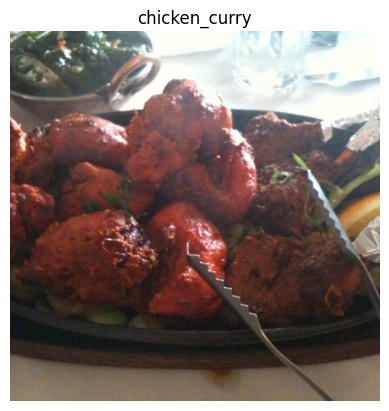

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc.)

However, not all data (including data from Tensorflow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 and 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, Tensorflow likes all of the tensors within a batch to be of same size
* Scaled (values between 0 and 1) also called normalized tensors, genrally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using EfficientNetBX pretrained from tf.keras.applications, we don't need to rescale our data (these architectures have rescaling built-in).

This means our function needs to:
 1. Reshape our images to all the same size
 2. Convert the dtype of our image tensors from `uint8` to `float32`

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatypes fromm 'uint8' -> 'float32' and reshapes
  imagem to [img_shape, image_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) #reshape target image
  #image = image/255. # scale image values (not require in efficientnet models)
  return tf.cast(image, tf.float32), label  # return a tuple of (float32_image, label)


In [ ]:
# Preprocess a single image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[170 193 165]
  [175 198 170]
  [187 209 186]
  ...
  [253 255 249]
  [253 255 249]
  [253 255 249]]

 [[169 185 159]
  [169 184 161]
  [171 189 167]
  ...
  [253 255 249]
  [253 255 249]
  [253 255 249]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>
Image after preprocessing:
 [[[170.5051  188.59184 163.11736]
  [187.9898  206.82143 186.91837]
  [208.97958 225.69388 212.7653 ]
  ...
  [253.      255.      249.     ]
  [253.      255.      249.     ]
  [253.      255.      249.     ]]

 [[155.02551 149.47958 134.38776]
  [149.11224 149.47958 137.11734]
  [153.97449 162.87245 152.42857]
  ...
  [253.      255.      249.     ]
  [253.      255.      249.     ]
  [253.      255.      249.     ]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch and Prepare datasets

We're now going to make our data input pipeline run really fast

In [ ]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it  (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to the test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, Tensorflow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new bacthes (prefetch) whilst the model is looking through (finding patterns) in the current batch"

## Creating modelling callbacks

We're going to create a couple of callbacks to help  us while our model trains:
 * Tensorboard callback to log training results (so we can visualize them later if need be)
 * ModelCheckpoint callback to save our model progress after feature extraction

In [ ]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckPoint allback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

## Setup mixed precision training

Mixed precision utilizes a combination of float32 and float16 datatypes to speed up model performance

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built in but if your model doesn't, you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False)  #makes sure layers which should be in inferencemode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies (are we using mixed precision?)

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_2 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen)
* `layer.dtype`: the datatype a layer store its variable in
* `layer.dtype_policy`: the datatype policy a layer computes on its variable with

In [ ]:
# Checkthe same attributes but for efficientnetb0 model
for layer in model.layers[1].layers[:20]: # Check the layers of the base model
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
rescaling_4 False float32 <Policy "mixed_float16">
normalization_2 False float32 <Policy "mixed_float16">
rescaling_5 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [ ]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230629-175409
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7202 - accuracy: 0.5796

2368/2368 [==============================] - 201s 77ms/step - loss: 1.7202 - accuracy: 0.5796 - val_loss: 1.1227 - val_accuracy: 0.6997
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2004 - accuracy: 0.6874

2368/2368 [==============================] - 187s 77ms/step - loss: 1.2004 - accuracy: 0.6874 - val_loss: 1.0349 - val_accuracy: 0.7198
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0535 - accuracy: 0.7244

2368/2368 [==============================] - 184s 76ms/step - loss: 1.0535 - accuracy: 0.7244 - val_loss: 0.9869 - val_accuracy: 0.7278


In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 56s 71ms/step - loss: 0.9967 - accuracy: 0.7306


[0.9966858625411987, 0.7305742502212524]